<a href="https://colab.research.google.com/github/saanchi-sk/NashvilleTornado/blob/main/Nash_Tornado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Tornado Damage

The aim of this project it to understand the correlation between damages observed during the 2019 tornadoes in Nashville and see if there many be any underlying relationships.

##Importing Libraries

I first importaed all the libraries i would need to run any analysis on the data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/GEOG485')

In [ ]:
! pip install geopandas
! pip install rtree
! pip install -U mapclassify
!apt install libspatialindex-dev
!pip install osmnx
!pip install contextily
!pip install cenpy #census data
!pip install hdbscan
!pip install matplotlib==3.1.3

     |████████████████████████████████| 1.0 MB 4.3 MB/s 
     |████████████████████████████████| 6.3 MB 36.9 MB/s 
     |████████████████████████████████| 16.7 MB 348 kB/s 
     |████████████████████████████████| 1.0 MB 4.3 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu

     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 2.4 MB 6.8 MB/s 
  Created wheel for cenpy: filename=cenpy-1.0.0.post4-py3-none-any.whl size=29924 sha256=1699837a044db3782665046056d069da7b87cf0d739dc26c39a64d3cd3ab6d9f
  Stored in directory: /root/.cache/pip/wheels/3c/6a/eb/8435134ce3552e7d9907378efdc19f5c167726dea64b8185d9
Successfully built cenpy
     |████████████████████████████████| 5.2 MB 4.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2330802 sha256=12fbfcf03af36d27c18976869096d9a1cf8ce696bdd8c63f6b34ce7adfd93f13
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan
     |████████████████████████████████| 13.1 MB 4.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing inst

In [ ]:
import numpy as np
import osmnx as ox
import xarray as xr
import requests
import pandas as pd
import geopandas as gpd
import contextily as cx
from scipy.spatial.distance import cdist
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt

## Reading the data 

The tornado data was gathered from the NOAA website, the damage data was from a previous site visit from the fulcrum app and the county and census shape files were taken from fata.gov.in.

The damage data was obtained by a webscapper since i did not have access to it directly. The webscaper was defined in my draft submission but has been removed from this notebook since it was heavy and the notebook kept hanging. I saved the csv from the webscaper and have implemented that directly in this notebook.

In [ ]:
#reading the required files

#tornadoes in the US
tornado_csv = pd.read_csv('/content/drive/MyDrive/GEOG485/Data/1950-2020_all_tornadoes.csv')

#damage data
damage_csv = pd.read_csv('/content/drive/MyDrive/GEOG485/Data/damage_csv.csv')

#shapefiles
tennessee= gpd.read_file(r'/content/drive/MyDrive/GEOG485/Data/tennesee/tn_counties.shp')
nashville=gpd.read_file(r'/content/drive/MyDrive/GEOG485/Data/nashvilleboundary/nashville.shp')


###Data Exploration

In [ ]:
tornado_csv.head()

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,...,15.8,10,1,1,1,25,0,0,0,0
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,...,2.0,880,1,1,1,47,0,0,0,0
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,...,0.1,10,1,1,1,177,0,0,0,0
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,...,0.1,10,1,1,1,209,0,0,0,0
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,...,2.0,37,1,1,1,101,0,0,0,0


In [ ]:
tornado_csv.columns

Index(['om', 'yr', 'mo', 'dy', 'date', 'time', 'tz', 'st', 'stf', 'stn', 'mag',
       'inj', 'fat', 'loss', 'closs', 'slat', 'slon', 'elat', 'elon', 'len',
       'wid', 'ns', 'sn', 'sg', 'f1', 'f2', 'f3', 'f4', 'fc'],
      dtype='object')

In [ ]:
tornado_csv=tornado_csv[['om', 'yr', 'mo', 'tz', 'st', 'stf', 'stn', 'mag',
       'inj', 'fat', 'loss',  'slat', 'slon', 'elat', 'elon', 'len',
       'wid',  'f1', 'f2', 'f3', 'f4', 'fc']]

In [ ]:
damage_csv.head()

,Unnamed: 0,mwfrs,storey,status,latitude,longitude
0,0,woodframe,1.0,2,36.175239,-85.620727
1,1,woodframe,1.0,2,36.175370,-85.579690
2,2,woodframe,1.0,2,36.177407,-85.591158
3,3,woodframe,1.0,2,36.175643,-85.579784
4,4,woodframe,1.0,4,36.175941,-85.585289


In [ ]:
damage_csv.mwfrs.unique()
#went back and renamed the column sin the csv since they were multiple lists within each entry

array(['woodframe', nan, 'masonry_r', 'concrete', 'steel', 'masonry_u',
       'masonry_urm', 'unknown'], dtype=object)

In [ ]:
tennessee.head()

,AREA,PERIMETER,TNCODD_,TNCODD_ID,INDEX_NO,COUNTY,STATE,geometry
0,0.128263,1.518444,2,77,59,Stewart,TN,"POLYGON ((1364976.405 793944.574, 1365282.971 ..."
1,0.124217,1.750500,3,81,62,Robertson,TN,"POLYGON ((1641280.781 842367.275, 1647007.140 ..."
2,0.141647,1.975747,4,82,64,Sumner,TN,"POLYGON ((1802978.842 837772.847, 1803032.828 ..."
3,0.141815,1.769964,5,84,60,Montgomery,TN,"POLYGON ((1485935.934 842978.481, 1490963.090 ..."
4,0.079980,1.244972,6,15,71,Macon,TN,"POLYGON ((1908481.094 839761.379, 1908485.571 ..."


In [ ]:
nashville.head()

,name,geometry
0,Historic Buena Vista,"POLYGON ((-86.79511 36.17576, -86.79403 36.176..."
1,Charlotte Park,"POLYGON ((-86.87460 36.15758, -86.87317 36.157..."
2,Hillwood,"POLYGON ((-86.87614 36.13554, -86.87583 36.135..."
3,East Hill,"POLYGON ((-86.74659 36.20376, -86.74559 36.203..."
4,Cleveland Park,"POLYGON ((-86.75606 36.18857, -86.75600 36.188..."


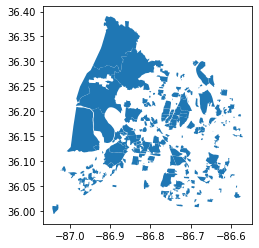

In [ ]:
nashville.plot()

##Plotting and clustering the tornadoes in Tennessee

In [ ]:
#select state columns as only kansas and 2019
tornado_csv = tornado_csv.loc[tornado_csv['st']=='TN']
# tornado_csv = tornado_csv.loc[tornado_csv['yr']=='2019']

In [ ]:
tornado_csv.head()
#only have TN data
#only used starting point since the ending lat longs are all 0.0

,om,yr,mo,tz,st,stf,stn,mag,inj,fat,...,slon,elat,elon,len,wid,f1,f2,f3,f4,fc
37,25,1950,2,3,TN,47,1,1,8,0,...,-89.77,0.0,0.0,0.2,10,157,0,0,0,0
38,26,1950,2,3,TN,47,2,2,1,9,...,-89.48,0.0,0.0,0.2,10,97,0,0,0,0
60,47,1950,3,3,TN,47,3,1,0,0,...,-85.77,0.0,0.0,0.2,10,177,0,0,0,0
213,246,1951,11,3,TN,47,1,2,0,0,...,-87.03,0.0,0.0,0.2,10,55,0,0,0,0
492,16,1952,2,3,TN,47,1,2,0,0,...,-88.12,0.0,0.0,0.3,300,5,0,0,0,0


In [ ]:
#draft a folium map
import folium

# Create a Folium map object
m = folium.Map(prefer_canvas=True, control_scale=True, max_zoom=20, tiles="cartodbpositron")

# Get the bounding box for mapping purpose
min_lat = tornado_csv['slat'].min()
min_lon = tornado_csv['slon'].min()
max_lat = tornado_csv['slat'].max()
max_lon = tornado_csv['slon'].max()
bound_box = [[min_lat, min_lon], [max_lat, max_lon]]

# Create the polyline object, replace None
folium.vector_layers.PolyLine(locations=tornado_csv[['slat','slon']].values,
                         color='#3388ff').add_to(m)

# Fit the map object with the bounding box
m.fit_bounds(bound_box)

# Show the map
m

In [ ]:
# a heat map to see the town in TN that are more prone to tornados
from folium.plugins import HeatMap

# Create a Map instance
m = folium.Map(location=[40.753869769191844, -73.98726201280635], tiles = 'cartodbpositron',
    zoom_start=12, control_scale=True)

# Add heatmap to map instance
# Available parameters: HeatMap(data, name=None, min_opacity=0.5, max_zoom=18, max_val=1.0, radius=25, blur=15, gradient=None, overlay=True, control=True, show=True)
HeatMap(tornado_csv[['slat','slon']].values).add_to(m)

# Alternative syntax:
#m.add_child(HeatMap(points_array, radius=15))

# Show map
m

It is evident from this plot that nashville has been a hot bed for tornadoes since 1950.

I wnated to limit the time period to the last 10 years and plot the tornadoes in TN just to see what are the differences, have the tornadoes increased or reduced during time

In [ ]:
tornado_csv_10_20 = tornado_csv[(2010<=tornado_csv.yr) & (tornado_csv.yr<=2020)]
tornado_csv_90_10 = tornado_csv[(1990<=tornado_csv.yr) & (tornado_csv.yr<=2010)]
tornado_csv_80_90 = tornado_csv[(1980<=tornado_csv.yr) & (tornado_csv.yr<=1990)]
tornado_csv_70_80 = tornado_csv[(1970<=tornado_csv.yr) & (tornado_csv.yr<=1980)]

In [ ]:
#checking if the previous function worked
tornado_csv_10_20.yr.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [ ]:
# a heat map to see the town in TN that are more prone to tornados
from folium.plugins import HeatMap

# Create a Map instance
m = folium.Map(location=[40.753869769191844, -73.98726201280635], tiles = 'cartodbpositron',
    zoom_start=12, control_scale=True)

# Add heatmap to map instance
# Available parameters: HeatMap(data, name=None, min_opacity=0.5, max_zoom=18, max_val=1.0, radius=25, blur=15, gradient=None, overlay=True, control=True, show=True)
HeatMap(tornado_csv_10_20[['slat','slon']].values).add_to(m)

# Alternative syntax:
#m.add_child(HeatMap(points_array, radius=15))

# Show map
m

In [ ]:
# a heat map to see the town in TN that are more prone to tornados
from folium.plugins import HeatMap

# Create a Map instance
m = folium.Map(location=[40.753869769191844, -73.98726201280635], tiles = 'cartodbpositron',
    zoom_start=12, control_scale=True)

# Add heatmap to map instance
# Available parameters: HeatMap(data, name=None, min_opacity=0.5, max_zoom=18, max_val=1.0, radius=25, blur=15, gradient=None, overlay=True, control=True, show=True)
HeatMap(tornado_csv_90_10[['slat','slon']].values).add_to(m)

# Alternative syntax:
#m.add_child(HeatMap(points_array, radius=15))

# Show map
m

In [ ]:
# a heat map to see the town in TN that are more prone to tornados
from folium.plugins import HeatMap

# Create a Map instance
m = folium.Map(location=[40.753869769191844, -73.98726201280635], tiles = 'cartodbpositron',
    zoom_start=12, control_scale=True)

# Add heatmap to map instance
# Available parameters: HeatMap(data, name=None, min_opacity=0.5, max_zoom=18, max_val=1.0, radius=25, blur=15, gradient=None, overlay=True, control=True, show=True)
HeatMap(tornado_csv_80_90[['slat','slon']].values).add_to(m)

# Alternative syntax:
#m.add_child(HeatMap(points_array, radius=15))

# Show map
m

In [ ]:
# a heat map to see the town in TN that are more prone to tornados
from folium.plugins import HeatMap

# Create a Map instance
m = folium.Map(location=[40.753869769191844, -73.98726201280635], tiles = 'cartodbpositron',
    zoom_start=12, control_scale=True)

# Add heatmap to map instance
# Available parameters: HeatMap(data, name=None, min_opacity=0.5, max_zoom=18, max_val=1.0, radius=25, blur=15, gradient=None, overlay=True, control=True, show=True)
HeatMap(tornado_csv_70_80[['slat','slon']].values).add_to(m)

# Alternative syntax:
#m.add_child(HeatMap(points_array, radius=15))

# Show map
m

From the heat maps plotted above, it can be seen that over the years Nashville has become more prone to tornadoes. Since it's one of the bigger cities of TN, the increased tornadoe will cause higher levels of damage and more economic loss.

In [ ]:
#convert to a geodataframe
tornado_strt_gdf = gpd.GeoDataFrame(tornado_csv, 
                                       geometry=gpd.points_from_xy(x=tornado_csv['slon'], y=tornado_csv['slat']))

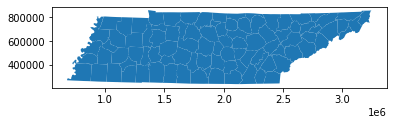

In [ ]:
tennessee.plot()

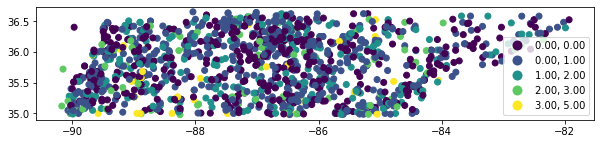

In [ ]:
# Plot on the map based on magnitude of the tornado
tornado_strt_gdf.plot(column='mag', figsize=(10,10), legend=True, scheme='NaturalBreaks')

##Building Damage data collected following the 2020 tornadoes


As listed previously, the building data was a csv, which was converted into a godataframe to overlay on the tornado data

In [ ]:
#geocoding the damage
damage_gdb= gpd.GeoDataFrame(damage_csv, 
                       geometry=gpd.points_from_xy(x=damage_csv['longitude'], y=damage_csv['latitude']),  #choosing 2 columns from the data #long lat is geographic coodinate system
                       crs='epsg:4326' )

In [ ]:
damage_gdb

,Unnamed: 0,mwfrs,storey,status,latitude,longitude,geometry
0,0,woodframe,1.0,2,36.175239,-85.620727,POINT (-85.62073 36.17524)
1,1,woodframe,1.0,2,36.175370,-85.579690,POINT (-85.57969 36.17537)
2,2,woodframe,1.0,2,36.177407,-85.591158,POINT (-85.59116 36.17741)
3,3,woodframe,1.0,2,36.175643,-85.579784,POINT (-85.57978 36.17564)
4,4,woodframe,1.0,4,36.175941,-85.585289,POINT (-85.58529 36.17594)
...,...,...,...,...,...,...,...
1095,1095,woodframe,2.0,4,36.188630,-86.398918,POINT (-86.39892 36.18863)
1096,1096,masonry_urm,1.0,4,36.175127,-86.736045,POINT (-86.73605 36.17513)
1097,1097,NaN,1.0,2,36.088226,-88.345776,POINT (-88.34578 36.08823)
1098,1098,woodframe,2.0,3,36.180201,-86.536403,POINT (-86.53640 36.18020)


In [ ]:
#dropping the nan values which was almost 300 rows
damage_gdb.dropna()

,Unnamed: 0,mwfrs,storey,status,latitude,longitude,geometry
0,0,woodframe,1.0,2,36.175239,-85.620727,POINT (-85.62073 36.17524)
1,1,woodframe,1.0,2,36.175370,-85.579690,POINT (-85.57969 36.17537)
2,2,woodframe,1.0,2,36.177407,-85.591158,POINT (-85.59116 36.17741)
3,3,woodframe,1.0,2,36.175643,-85.579784,POINT (-85.57978 36.17564)
4,4,woodframe,1.0,4,36.175941,-85.585289,POINT (-85.58529 36.17594)
...,...,...,...,...,...,...,...
1093,1093,unknown,1.0,4,36.185479,-86.631127,POINT (-86.63113 36.18548)
1095,1095,woodframe,2.0,4,36.188630,-86.398918,POINT (-86.39892 36.18863)
1096,1096,masonry_urm,1.0,4,36.175127,-86.736045,POINT (-86.73605 36.17513)
1098,1098,woodframe,2.0,3,36.180201,-86.536403,POINT (-86.53640 36.18020)


since mwfrs is a vital part of understandinf whether or not hte building did get damgaed, i have first looked at the unique values present in the column and manually encoded them so they may be plotted more easily.

In [ ]:
damage_gdb.mwfrs.unique()

array(['woodframe', nan, 'masonry_r', 'concrete', 'steel', 'masonry_u',
       'masonry_urm', 'unknown'], dtype=object)

With my particular interet being in unreinforced masonry, i have encoded that at 0 and the rest as 1

In [ ]:
#check masonry
def check_mwfrs(row):
  return 1 if row == 'masonry_urm' else 0


In [ ]:
damage_gdb['mwfrs'].head()

0    woodframe
1    woodframe
2    woodframe
3    woodframe
4    woodframe
Name: mwfrs, dtype: object

In [ ]:
damage_gdb['mwfrs_label']= damage_gdb.mwfrs.apply(check_mwfrs)

In [ ]:
damage_gdb.loc[(damage_gdb.mwfrs_label == 1), ['mwfrs','mwfrs_label']]

,mwfrs,mwfrs_label
27,masonry_urm,1
203,masonry_urm,1
406,masonry_urm,1
407,masonry_urm,1
594,masonry_urm,1
907,masonry_urm,1
1096,masonry_urm,1


Since these values are very limited, and we don't know how accuractely or inaccurately the data was gather on-site. I converted all masonry into 1 and the rest as 0.

In [ ]:
def check_mwfrs_all(row):
  if (row == 'masonry_urm') or (row == 'masonry_u') or (row == 'masonry_r'):
    return 1
  if (row == 'woodframe'):
    return 2
  if (row == 'concrete') or (row == 'steel'):
    return 3
  else:
    return 0



In [ ]:
damage_gdb['mwfrs_label']= damage_gdb.mwfrs.apply(check_mwfrs_all)

In [ ]:
damage_gdb.loc[(damage_gdb.mwfrs_label == 1), ['mwfrs','mwfrs_label']]

,mwfrs,mwfrs_label
19,masonry_r,1
23,masonry_u,1
25,masonry_u,1
27,masonry_urm,1
29,masonry_u,1
30,masonry_r,1
31,masonry_r,1
179,masonry_u,1
203,masonry_urm,1
369,masonry_r,1


In [ ]:
damage_gdb['mwfrs_label'].value_counts()

2    662
0    397
1     28
3     13
Name: mwfrs_label, dtype: int64

We still see that there are not many masonry buildings within the region.

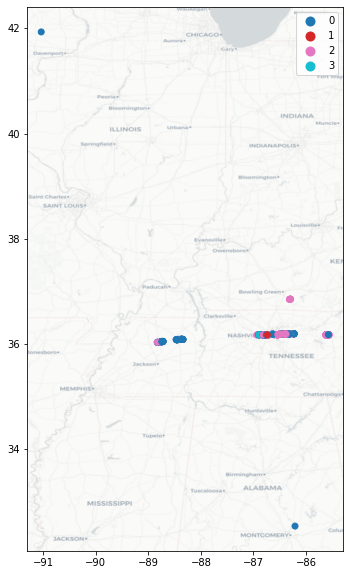

In [ ]:
# Plot on the map
f, ax = plt.subplots(1, figsize=(10,10))
damage_gdb.plot(column='mwfrs_label',ax=ax, legend=True, categorical=True)
# Add basemap
cx.add_basemap(ax, crs=damage_gdb.crs, source=cx.providers.CartoDB.Positron)

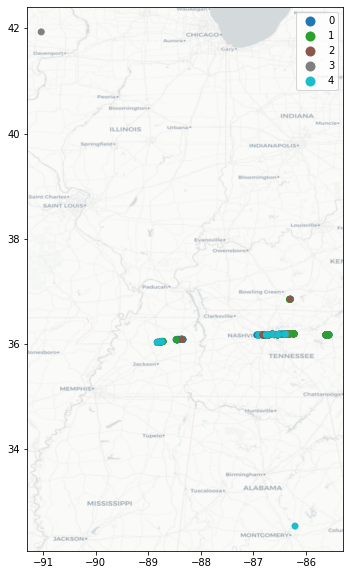

In [ ]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(10,10))

damage_gdb.plot(column='status',  ax=ax, legend=True, categorical=True)

# Add basemap
cx.add_basemap(ax, crs=damage_gdb.crs, source=cx.providers.CartoDB.Positron)

Since the tornado was majorly concentrated in Tennessee, that was the focus of this project

In [ ]:
#drop the rows where the storey is 1.5 and 2.5, since unclear of that migth mean
damage_gdb = damage_gdb.loc[damage_gdb['storey'] !='1.5']
damage_gdb = damage_gdb.loc[damage_gdb['storey'] !='2.5']
damage_gdb 

,Unnamed: 0,mwfrs,storey,status,latitude,longitude,geometry,mwfrs_label
0,0,woodframe,1.0,2,36.175239,-85.620727,POINT (-85.62073 36.17524),2
1,1,woodframe,1.0,2,36.175370,-85.579690,POINT (-85.57969 36.17537),2
2,2,woodframe,1.0,2,36.177407,-85.591158,POINT (-85.59116 36.17741),2
3,3,woodframe,1.0,2,36.175643,-85.579784,POINT (-85.57978 36.17564),2
4,4,woodframe,1.0,4,36.175941,-85.585289,POINT (-85.58529 36.17594),2
...,...,...,...,...,...,...,...,...
1095,1095,woodframe,2.0,4,36.188630,-86.398918,POINT (-86.39892 36.18863),2
1096,1096,masonry_urm,1.0,4,36.175127,-86.736045,POINT (-86.73605 36.17513),1
1097,1097,NaN,1.0,2,36.088226,-88.345776,POINT (-88.34578 36.08823),0
1098,1098,woodframe,2.0,3,36.180201,-86.536403,POINT (-86.53640 36.18020),2


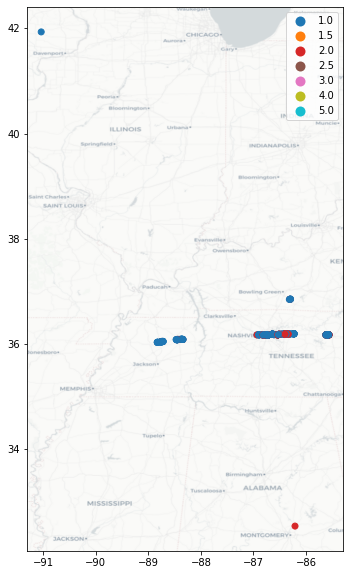

In [ ]:
# damage_gdb.plot(column='storey', figsize=(10,10), legend=True, categorical=True)

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(10,10))

damage_gdb.plot(column='storey',  ax=ax, legend=True, categorical=True)

# Add basemap
cx.add_basemap(ax, crs=damage_gdb.crs, source=cx.providers.CartoDB.Positron)

##Has Nashville always been prone to tornadoes

In [ ]:
tornado_strt_gdf = tornado_strt_gdf.set_crs('epsg:4326')

In [ ]:
damage_gdb = damage_gdb.set_crs('epsg:4326') 

In [ ]:
damage_gdb.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
tornado_strt_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

For estimating the distance from between the tornado and the buidling, i will first calculated the centeroids of the tornado, but since my geometry is already points I will not have to do that.

In [ ]:
nashville.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [ ]:
# Import the geocoding tool
from geopandas.tools import geocode

# Geocode downtown Nashville using Nominatim
nash_dt = geocode('Nissan Stadium, Nashville, US', provider='nominatim', user_agent='autogis_xx', timeout=4) #only geocoding the string

# check data
nash_dt

,geometry,address
0,POINT (-86.77126 36.16650),"Nissan Stadium, Russell Street, East Nashville..."


In [ ]:
nashville = nashville.to_crs('epsg:4326') 

In [ ]:
nash_dt.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# add distance to between nashville and the buildings
damage_gdb['d2nash_dt']= damage_gdb.distance(nash_dt.at[0, 'geometry'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


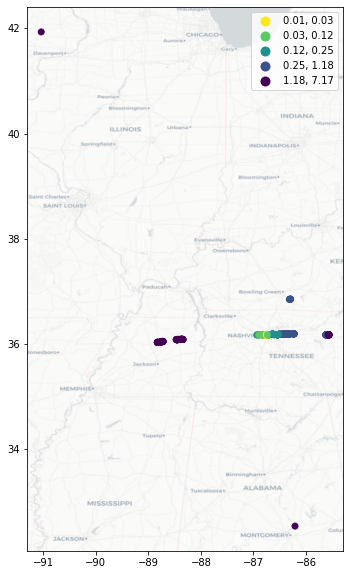

In [ ]:
f, ax = plt.subplots(1, figsize=(10,10))
damage_gdb.plot(column='d2nash_dt',ax=ax, scheme='quantiles', cmap='viridis_r', legend=True)
# Add basemap
cx.add_basemap(ax, crs=damage_gdb.crs, source=cx.providers.CartoDB.Positron)

It can be seen that most of the damages buildings were closer to Nashville 

In [ ]:
# check the distance from the tornado to nashdt
tornado_strt_gdf['d2nash_dt']= tornado_strt_gdf.distance(nash_dt.at[0, 'geometry'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


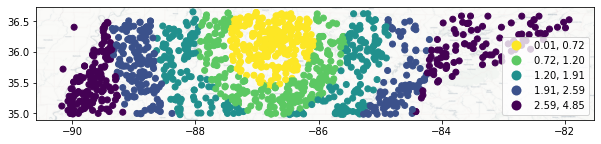

In [ ]:
f, ax = plt.subplots(1, figsize=(10,10))
tornado_strt_gdf.plot(column='d2nash_dt', figsize=(10,10),ax=ax, scheme='quantiles', cmap='viridis_r', legend=True)
# Add basemap
cx.add_basemap(ax, crs=damage_gdb.crs, source=cx.providers.CartoDB.Positron)

There have been multiple tornadoes very close to the city center of Nashville in the last 50 years.

##Looking at Damages specific to Nashville

Since i am interested in tornadoes from 2019, I filtered out the tornado to only include those

In [ ]:
#since we are only interested in EF3 or higher, we remove the other points
tornado_strt_gdf= tornado_strt_gdf.loc[tornado_strt_gdf['yr'] >2018]

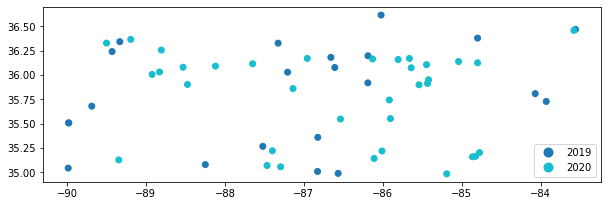

In [ ]:
tornado_strt_gdf.plot(column='yr', figsize=(10,10), legend=True, categorical=True)

Since the tornado occure in 2020, i again filtered the tornado dataframe to only include those points

In [ ]:
tornado_strt_gdf= tornado_strt_gdf.loc[tornado_strt_gdf['yr'] >2019]

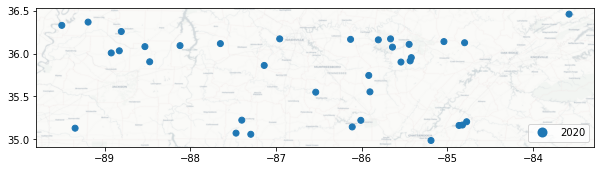

In [ ]:
f, ax = plt.subplots(1, figsize=(10,10))
tornado_strt_gdf.plot(column='yr', ax=ax, legend=True, categorical=True)
# Add basemap
cx.add_basemap(ax, crs=damage_gdb.crs, source=cx.providers.CartoDB.Positron)

And i plotted the tornado map for nashville

In [ ]:
tornado_strt_gdf = tornado_strt_gdf.reindex()

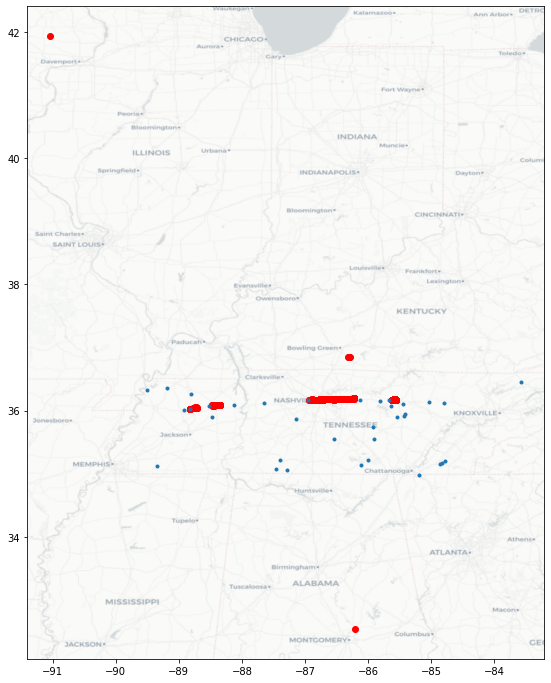

In [ ]:
# plot both the tornado and buidlings on a map 
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(12, 12))

# Plot buildings on the map
damage_gdb.plot(ax=ax, color='r')


# Plot POIs in red
tornado_strt_gdf.plot(ax=ax, marker='.')

# Add CartoDB basemap
cx.add_basemap(
    ax, 
    crs=damage_gdb.crs.to_string(), 
    source=cx.providers.CartoDB.Positron
)

# Display
plt.show()

We can see that the building that were assessed lay directly on the tornado path.

##Looking at the impacted population in Nashville

I then looked at the differnt subuerbs in nashville that may have been impacted during the tornado.

In [ ]:
nashville.head()

,name,geometry
0,Historic Buena Vista,"POLYGON ((-86.79511 36.17576, -86.79403 36.176..."
1,Charlotte Park,"POLYGON ((-86.87460 36.15758, -86.87317 36.157..."
2,Hillwood,"POLYGON ((-86.87614 36.13554, -86.87583 36.135..."
3,East Hill,"POLYGON ((-86.74659 36.20376, -86.74559 36.203..."
4,Cleveland Park,"POLYGON ((-86.75606 36.18857, -86.75600 36.188..."


In [ ]:
%%time

import cenpy

acs = cenpy.products.ACS()
na_pop = acs.from_msa(
    "Nashville, TN",
    level = "tract",
    variables=['B02001_001E'] # total estimate. https://api.census.gov/data/2018/acs/acs5/groups/B02001.html
    )

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/usr/local/lib/python3.7/dist-pac

CPU times: user 4.39 s, sys: 335 ms, total: 4.73 s
Wall time: 2min 17s


/usr/local/lib/python3.7/dist-packages/cenpy/products.py:749: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  msa, variables, level, "Metropolitan Statistical Area", **kwargs


In [ ]:
na_pop.head()

,GEOID,geometry,B02001_001E,NAME,state,county,tract
0,47119010900,"POLYGON ((-9724241.200 4245364.980, -9724240.8...",3275.0,"Census Tract 109, Maury County, Tennessee",47,119,010900
1,47043060300,"POLYGON ((-9718154.700 4315022.770, -9718138.1...",7015.0,"Census Tract 603, Dickson County, Tennessee",47,043,060300
2,47119011102,"POLYGON ((-9695122.250 4235011.930, -9695115.0...",2902.0,"Census Tract 111.02, Maury County, Tennessee",47,119,011102
3,47119010201,"POLYGON ((-9694048.800 4257894.520, -9694043.7...",6623.0,"Census Tract 102.01, Maury County, Tennessee",47,119,010201
4,47187051002,"POLYGON ((-9668122.490 4273909.490, -9668093.5...",7204.0,"Census Tract 510.02, Williamson County, Tennessee",47,187,051002


In [ ]:
na_pop.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
na_pop= na_pop.to_crs('epsg:4326')

In [ ]:
na_pop["density"] = na_pop["B02001_001E"]/ na_pop.area

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [ ]:
# Create a mask and fill nan values when points are outside nashville
damage_nash_sjoin =damage_gdb.sjoin(nashville, predicate='within', how='left')

In [ ]:
damage_nash_sjoin.head()

,Unnamed: 0,mwfrs,storey,status,latitude,longitude,geometry,mwfrs_label,d2nash_dt,index_right,name
0,0,woodframe,1.0,2,36.175239,-85.620727,POINT (-85.62073 36.17524),2,1.150571,NaN,NaN
1,1,woodframe,1.0,2,36.175370,-85.579690,POINT (-85.57969 36.17537),2,1.191607,NaN,NaN
2,2,woodframe,1.0,2,36.177407,-85.591158,POINT (-85.59116 36.17741),2,1.180157,NaN,NaN
3,3,woodframe,1.0,2,36.175643,-85.579784,POINT (-85.57978 36.17564),2,1.191515,NaN,NaN
4,4,woodframe,1.0,4,36.175941,-85.585289,POINT (-85.58529 36.17594),2,1.186013,NaN,NaN


In [ ]:
# create a new column saving whether the grid is inside ca_boundary
damage_gdb['inside'] = 1 

# change the value to 0 when grid is outside
damage_gdb.loc[damage_nash_sjoin['index_right'].isna(), 'inside'] = 0

In [ ]:
damage_gdb.head()

,Unnamed: 0,mwfrs,storey,status,latitude,longitude,geometry,mwfrs_label,d2nash_dt,inside
0,0,woodframe,1.0,2,36.175239,-85.620727,POINT (-85.62073 36.17524),2,1.150571,0
1,1,woodframe,1.0,2,36.175370,-85.579690,POINT (-85.57969 36.17537),2,1.191607,0
2,2,woodframe,1.0,2,36.177407,-85.591158,POINT (-85.59116 36.17741),2,1.180157,0
3,3,woodframe,1.0,2,36.175643,-85.579784,POINT (-85.57978 36.17564),2,1.191515,0
4,4,woodframe,1.0,4,36.175941,-85.585289,POINT (-85.58529 36.17594),2,1.186013,0


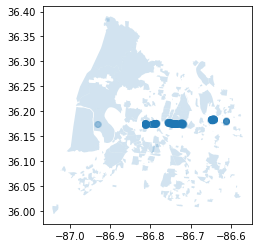

In [ ]:
ax = nashville.plot(alpha=0.2)
damage_gdb.loc[damage_gdb['inside'] == 1].plot(ax=ax,alpha=0.2)

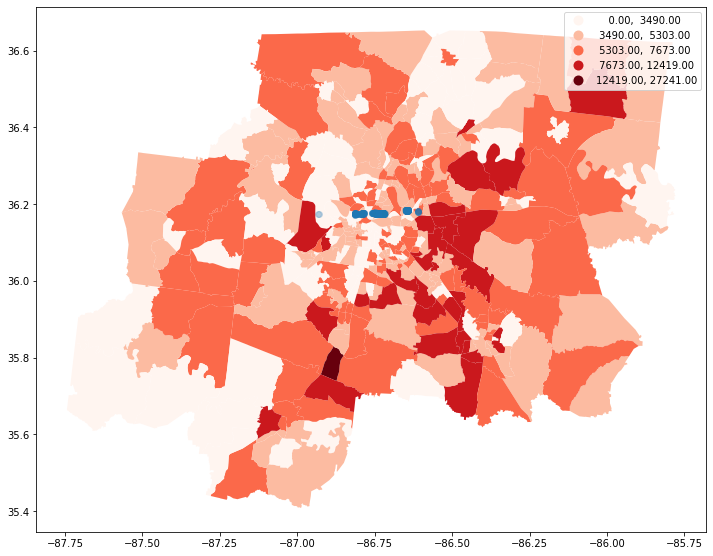

In [ ]:
# plot this
ax = na_pop.plot(column='B02001_001E', scheme='NaturalBreaks', legend=True, cmap='Reds', figsize=(12,12))
damage_gdb.loc[damage_gdb['inside'] == 1].plot(ax=ax,alpha=0.2)

Luckily, the tornado did not strike the denser areas of Nashville. I  then looked at the population density of buildings that were damaged

In [ ]:
j = damage_gdb.sjoin(na_pop)
#can do within too, same results

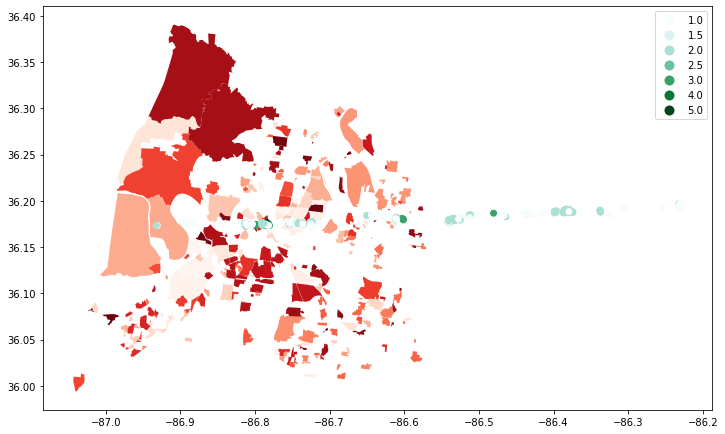

In [ ]:
# plot this
ax = nashville.plot(figsize=(12,12), cmap='Reds')
j.plot(column='storey', legend=True, cmap='BuGn', ax=ax, categorical=True)


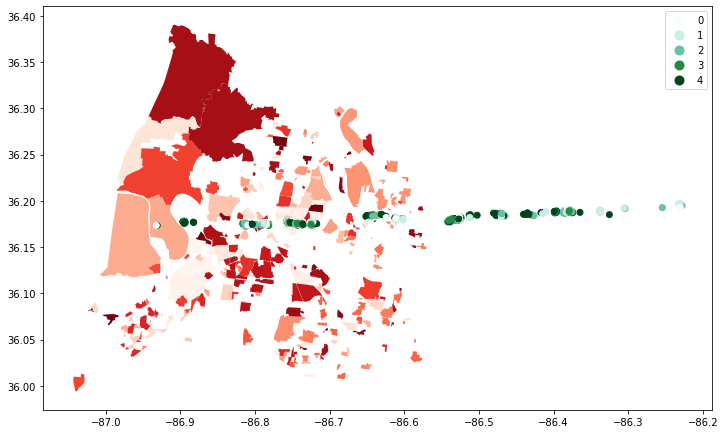

In [ ]:
ax = nashville.plot(figsize=(12,12),cmap='Reds')
j.plot(column='status', legend=True, cmap='BuGn', ax=ax, categorical=True)

##Conclusion

I used this project to solidify some of the concepts i learnt during the class and apply them to my research. Since the datasets i used were very varied and did not have overlapping details, using all of them together was tricky.  This is why the project was broken up into smaller portions to understand the impact of tornadoes with respect to the building data and population. In retrospect, it might have been a good idea to utilize general building data from open maps and plot those along with the damaged buildings to get a better understanding the widespread damage. 

As for this project, I can conclude the following:


*  Nashville has always been prone to tornadoes
*  During the 2020 tornado, the eastern part of Nashville was more impacted
*  The number of storeys had a correlation with the damage level
*  The two storey masonry buildings underwent a higher level of damage


